#  NBA Fantasy Points Analysis
This notebook analyzes NBA Fantasy data to test the hypothesis that player **position** has a significant effect on fantasy performance. by using ESPN API to collect data, run statistical tests, and train regression models to evaluate the impact of stats and position.

In [2]:

import json
import pandas as pd
from espn_api.basketball import League

def fetch_all_player(league):
    all_players = []
    for team in league.teams:
        all_players.extend(team.roster)
    all_players.extend(league.free_agents(size=500))

    player_data = [
        {
            "name": player.name,
            "position": player.position,
            "team": player.proTeam,
            "total_points": player.total_points
        }
        for player in all_players
    ]

    with open("all_players.json", "w") as file:
        json.dump(player_data, file, indent=4)

    print("All player data has been saved to 'all_players.json'.")

def save_historical_data(league, total_weeks=10):
    historical_data = []
    for week in range(1, total_weeks + 1):
        box_scores = league.box_scores(matchup_period=week)
        for box in box_scores:
            for player in box.home_lineup + box.away_lineup:
                stats = player.points_breakdown or {}
                historical_data.append({
                    "Week": week,
                    "Player": player.name,
                    "Position": player.position,
                    "Team": player.proTeam,
                    "3PM": stats.get('3PM', 0),
                    "REB": stats.get('REB', 0),
                    "AST": stats.get('AST', 0),
                    "STL": stats.get('STL', 0),
                    "BLK": stats.get('BLK', 0),
                    "TO": stats.get('TO', 0),
                    "PTS": stats.get('PTS', 0),
                    "Fantasy_Points": player.points
                })

    historical_df = pd.DataFrame(historical_data)
    historical_df.to_csv('historical_player_data.csv', index=False)
    print("Historical data saved to 'historical_player_data.csv'.")


In [3]:

from espn_api.basketball import League
from collect_data import fetch_all_player, save_historical_data

league_id = 1937531242
season_year = 2025
swid = "{B3AC659D-1A6F-4431-8A6B-45355773BA9C}"
espn_s2 = ("AEBXZygTTQ9lwpUMTjrlaqi70u8ao47ec7vHdc2RdJOJewjYfOorUs6N4"
           "20yeu%2BXAZWkDn96Kn7EQUYvOcw%2B%2FIZ17%2BX38ERVTllLHhS5g%"
           "2FYTyMrEPRUAdp99PkVDcG0naoFyXgR42uPR3Ijqsstn7NmDeWnvFxQ%2"
           "FVmN%2FkbPOOw8M2Wh9Po9pWAx88uBDYWAbs1BC%2BpTLmFRbhVr%2Fucv2"
           "qQrPB9Lwp5ofYomhG49sv%2FIXQ7elCmhdR9ISk7uYtKbtewNwjFNLPGAhHK"
           "CKmeG%2Fu63xXa91ylmdR%2Fp54PhV68pJJg%3D%3D")

league = League(league_id=league_id, year=season_year, swid=swid, espn_s2=espn_s2)

fetch_all_player(league)
save_historical_data(league, total_weeks=10)


All player data has been saved to 'all_players.json'.
Historical data saved to 'historical_player_data.csv'.


## Position-Based Analysis & ANOVA

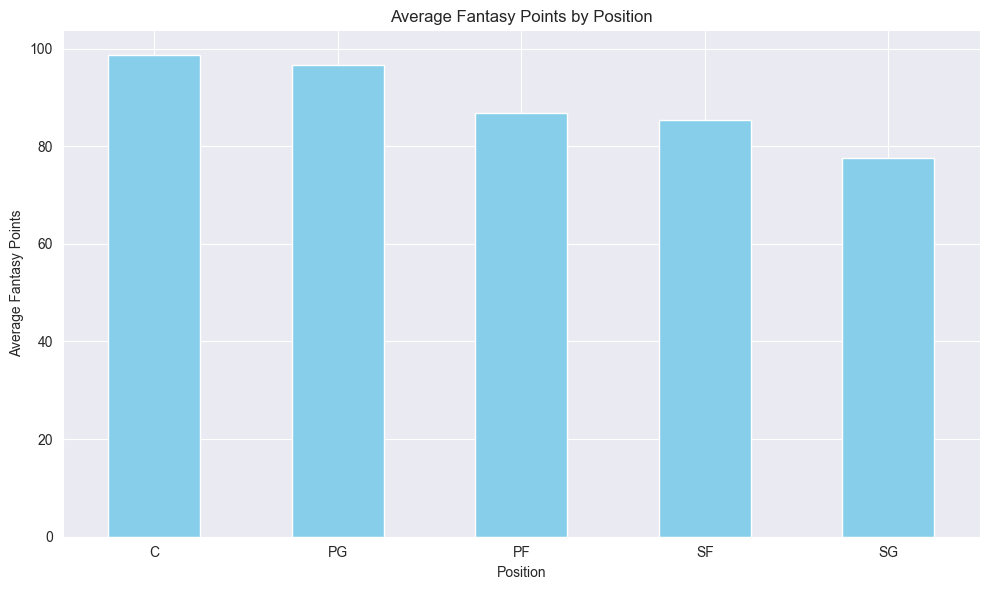

ANOVA p-value: 1.21624e-08
Statistically significant difference in fantasy points by position.


In [7]:

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import os

df = pd.read_csv("historical_player_data.csv")
df = df.dropna(subset=["Position", "Fantasy_Points"])
avg_points_by_position = df.groupby("Position")["Fantasy_Points"].mean().sort_values(ascending=False)

os.makedirs("figure", exist_ok=True)

plt.figure(figsize=(10, 6))
avg_points_by_position.plot(kind='bar', color='skyblue')
plt.title("Average Fantasy Points by Position")
plt.xlabel("Position")
plt.ylabel("Average Fantasy Points")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("figure/position_avg_points.png")
plt.show()

groups = [group["Fantasy_Points"].values for _, group in df.groupby("Position") if len(group) > 1]
anova_result = f_oneway(*groups)

print(f"ANOVA p-value: {anova_result.pvalue:.5e}")
if anova_result.pvalue < 0.05:
    print("Statistically significant difference in fantasy points by position.")
else:
    print("No statistically significant difference found.")


##  Regression Model with Position as Feature

Mean Squared Error: 15.96
R² Score: 0.9940
        Feature  Coefficient
7    Position_C     1.616747
5            TO     1.216626
6           PTS     1.197460
1           REB     1.011964
4           BLK     0.986675
2           AST     0.984615
3           STL     0.955000
0           3PM     0.899598
8   Position_PF    -0.066342
10  Position_SF    -0.198476
11  Position_SG    -0.543696
9   Position_PG    -0.808233


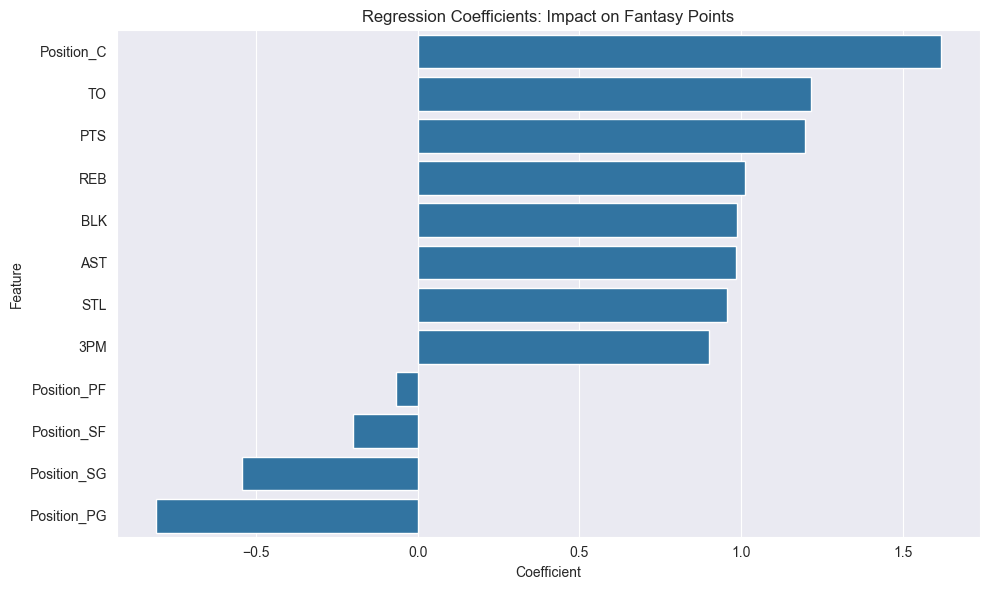

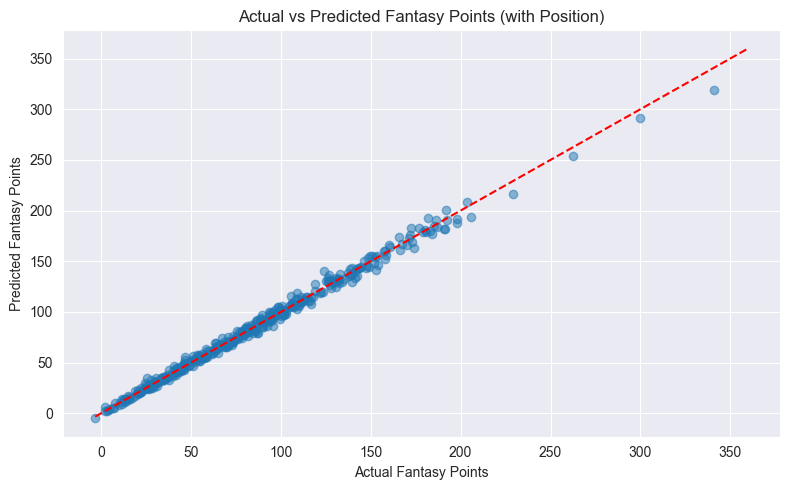

In [13]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

df = pd.read_csv("historical_player_data.csv")
df = df.dropna(subset=["Fantasy_Points", "3PM", "REB", "AST", "STL", "BLK", "TO", "PTS", "Position"])
stat_features = ["3PM", "REB", "AST", "STL", "BLK", "TO", "PTS"]
X = df[stat_features + ["Position"]]
y = df["Fantasy_Points"]

X = pd.get_dummies(X, columns=["Position"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.4f}")

coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": reg.coef_
}).sort_values(by="Coefficient", ascending=False)
print(coef_df)

plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y="Feature", data=coef_df, legend=False)
plt.title("Regression Coefficients: Impact on Fantasy Points")
plt.tight_layout()
plt.savefig("figure/feature_importance_with_position.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Fantasy Points")
plt.ylabel("Predicted Fantasy Points")
plt.title("Actual vs Predicted Fantasy Points (with Position)")
plt.tight_layout()
os.makedirs("figure", exist_ok=True)
plt.savefig("figure/regression_actual_vs_predicted_with_position.png")
plt.show()


###  Final Thoughts
- regression model shows how in-game stats and position contribute to fantasy point predictions.
- The ANOVA test confirms whether positional differences are statistically significant.
- Combined, these tools support your **hypothesis** that roster decisions can be improved with a data-driven, position-aware strategy.